# Get g distribution for a synthetic transit

Transit modeling with batman https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import photoeccentric as ph
from tqdm import tqdm
import batman

import astropy.units as u
from astropy.timeseries import BoxLeastSquares

from scipy.optimize import curve_fit

import emcee

import PyAstronomy.pyasl as pya

### Functions used in this notebook defined here

In [46]:
#Assuming a circular orbit --

def get_T23(p, rprs, T14, a, i):
    """
    Period: seconds
    rprs: rp in stellar radii
    T14: seconds
    a: semi-major axis in stellar radii
    i: degrees
    """
    
    ing_eg = 2*pya.ingressDuration_Rs(a, rprs, i, p)
    
    T23 = T14-ing_eg
    
    return T23

In [3]:
def density(mass, radius, norm=None):
    """Get density of sphere given mass and radius.

    Parameters
    ----------
    mass: float
        Mass of sphere (kg)
    radius: float
        Radius of sphere (m)
    norm: float, default None
        Value to normalize to (kg m^-3)
    """

    if norm==None:
        return ((mass)/((4./3.)*np.pi*radius**3))
    else:
        return ((mass)/((4./3.)*np.pi*radius**3))

In [55]:
def find_density_dist_symmetric(ntargs, masses, masserr, radii, raderr):
    """Gets symmetric stellar density distribution for stars.
    Symmetric stellar density distribution = Gaussian with same sigma on each end.

    Parameters
    ----------
    ntargs: int
        Number of stars to get distribution for
    masses: np.ndarray
        Array of stellar masses (solar mass)
    masserr: np.ndarray
        Array of sigma_mass (solar mass)
    radii: np.ndarray
        Array of stellar radii (solar radii)
    raderr: np.ndarray
        Array of sigma_radius (solar radii)

    Returns
    -------
    rho_dist: np.ndarray
        Array of density distributions for each star
        Each element length 1000
    mass_dist: np.ndarray
        Array of symmetric Gaussian mass distributions for each star
        Each element length 1000
    rad_dist: np.ndarray
        Array of symmetric Gaussian radius distributions for each star
        Each element length 1000
    """

    rho_dist = np.zeros((ntargs, 1000))
    mass_dist = np.zeros((ntargs, 1000))
    rad_dist = np.zeros((ntargs, 1000))

    #star: indexing star
    #point: indexing PDF point for star
    for star in tqdm(range(ntargs)):

        rho_temp = np.zeros(1000)
        mass_temp = np.zeros(1000)
        rad_temp = np.zeros(1000)

        #####
        
        mass_temp = np.random.normal(masses[star], masserr[star], 1000)
        #len 1200
        rad_temp = np.random.normal(radii[star], raderr[star], 1000)
        #len 1200
        #####

        #for j from 0 to 1200
        #for each point in individual star PDF
        #Adding each density point to rho_temp (specific to this star)
        for point in range(len(mass_temp)):
            #if mass_dist[point] >= 0. and rad_dist[point] >= 0:
            rho_temp[point] = density(mass_temp[point], rad_temp[point])

        #Now rho_temp is a n-long array with this star. We want it to be 1000-long exactly

        while len(rho_temp) > 1000:
            temp_ind = np.random.randint(0, len(rho_temp)-1)
            rho_temp = np.delete(rho_temp, temp_ind)
            mass_temp = np.delete(mass_temp, temp_ind)
            rad_temp = np.delete(rad_temp, temp_ind)
        else:
            rho_dist[star] = rho_temp
            mass_dist[star] = mass_temp
            rad_dist[star] = rad_temp

    return rho_dist, mass_dist, rad_dist

In [56]:
def get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, rpearth, rpeartherr, rs, rserr, a, i, T14, T14err, n_rhos):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    row: int
        Row in pandas.dataframe of info from Exoplanet Archive. (change this to take KIC/KOI)
    n_rhos: int
        Number of values in distribution
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    gs = np.zeros((len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = np.random.normal(p, perr, size=1000)
    
    rs_dist = np.random.normal(rs, rserr, size=1000)
    rp_earth_dist = np.random.normal(rpearth, rpeartherr, size=1000)
    
    rprs_dist = np.random.normal(rprs, rprserr, size=1000)

    T14_dist = np.random.normal(T14, T14err, size=1000)

    #for j in tqdm(range(len(rhos))): #for element in histogram for star:
    for j in tqdm(range(100)):

        per_dist[j] = per_dist[j]*86400.
        T14_dist[j] = T14_dist[j]*3600.
        
        T23_dist[j] = get_T23(per_dist[j], rprs_dist[j], T14_dist[j], a, i)#Period and T14 need to be in seconds. Then T23 will be in seconds.
        
        rho_circ[j] = ph.get_rho_circ(rprs_dist[j], T14_dist[j], T23_dist[j], per_dist[j])

        g = ph.get_g(rho_circ[j], rhos[j])
        gs[j] = g

        
        
    return gs

## Star: 

Assuming an M5 star

### Mass 
mass = 0.18 +/- 0.02 Msol

3.5E29 +/- 4E28 kg

### Radius 
rs = 0.2 +/- 0.01 solar radii

139.14E6 +/- 6.9E6 meters

### Limb darkening

Linear, u=0.7

## Planet:

### Period 
per = 5 days

### Radius 
rprs = 0.07 +/- 0.01 stellar radii

rp_earth = 1.52 +/- 0.2 earth radii

9.73E6 +/- 1.4E6 meters

### Eccentricity 
e = 0.1

### Omega
w = 100 (Degrees)

### Inclination
i = 88.5

### Semimajor axis
a = 15 stellar radii

0.014 AU

2.09E9 meters

### Transit duration
Full transit

T14 = 0.6 hours

36 minutes

2160 seconds





In [57]:
""" Creating mass, masserr, radius, and raderr arrays """

masses = [np.random.normal(3.5E29, 4.0E28, size=100)]
radii = [np.random.normal(139.14E6, 6.9E6, size=100)]

###### Find the density of this "star" based on available information (mass and radius)

In [60]:
rho = find_density_dist_symmetric(1, [2.8E29], [4.0E28], [139.14E6], [6.9E6])
rho[0].flatten();
rhos = rho[0][0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

100%|██████████| 1/1 [00:00<00:00, 320.27it/s]


In [73]:
np.mean(rhos)

25275.474136013992

##### Create a transit model with planet params above.

In [74]:
time = np.linspace(-14, 14, 3000)

In [165]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                        #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.4                       #eccentricity
    params.w = -90.0                        #longitude of periastron (in degrees)
    params.limb_dark = "linear"        #limb darkening model
    params.u = [0.3]

    #times at which to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [166]:
flux = planetlc(time, 5., 0.07, 15., 89.8)

# Adding gaussian noise
noise = np.random.normal(0,0.0001,len(time))
nflux = flux+noise

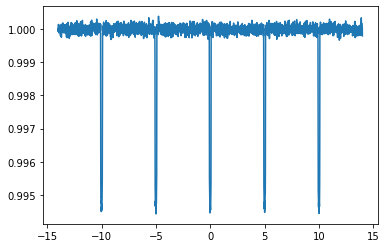

In [167]:
plt.plot(time, nflux)

## Fit transit

#### Astropy BLS

In [168]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

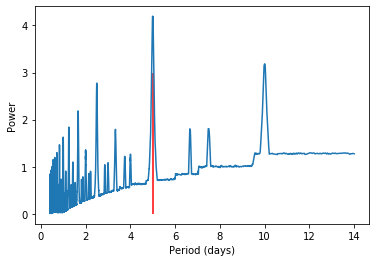

In [169]:
plt.plot(periodogram.period, periodogram.power)
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.vlines(per_guess, 0, 3, color='r')

#### Least-squares using BLS period guess

In [170]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, 0.08, 15, 89.8]
popt, pcov = curve_fit(planetlc, xdata=time, ydata=nflux, p0=p0)
fit = planetlc(time, *popt)

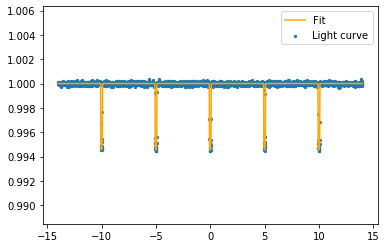

In [171]:
plt.scatter(time, nflux, label='Light curve', s=5)
plt.plot(time, fit, label='Fit', c='orange')
plt.legend()

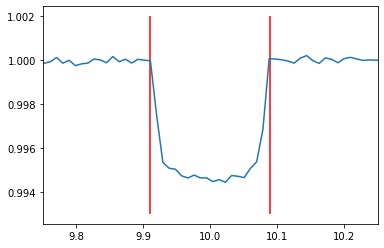

In [177]:
plt.plot(time, nflux)
plt.xlim(9.75, 10.25)

plt.vlines(9.91, 0.993, 1.002, color='r')
plt.vlines(10.09, 0.993, 1.002, color='r')

In [178]:
p = popt[0] #4.99 days
perr = 0.1

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.01

# Assuming 0.2 Rsun stellar radius
#a = 0.01366052 #AU
a = 14.68 #stellar radii

i = popt[3]

T14 = 0.18*24 #hours
T14err = 0.01 #hours

rpearth = 1.5 #earth radii
rpeartherr = 0.1

rs = 0.2 #solar radii
rserr = 0.01

In [179]:
gs_t = get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, rpearth, rpeartherr, rs, rserr, a, i, T14, T14err, 100)
gs = gs_t[0:100]

100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


In [180]:
gs_sigmaminus, gs_sigmaplus = ph.get_sigmas(gs)

In [181]:
np.mean(gs)

0.36236914789265484

e=0, w=0:
g = 0.56

e=0.2, w=100:
g = 0.49

e=0.2, w=-90:
g = 0.4

e = 0.4, w=100:
g = 0.6

e = 0.4, w=-90:
g = 0.36


In [182]:
def log_likelihood(theta, g, gerr):
    """Log of likelihood
    model = g(e,w)
    gerr = sigma of g distribution
    """
    w, e = theta
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    w, e = theta
    if 0.0 < e < 1.0 and -90.0 < w < 300.0:
        return 0.0
    return -np.inf

def log_probability(theta, g, gerr):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, g, gerr)

In [183]:
#Guesses
w_guess = -90.0
e_guess = 0.4

In [184]:
solnx = (w_guess, e_guess)

In [185]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [186]:
g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [187]:
g_mean

0.36236914789265484

In [192]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 693.66it/s]


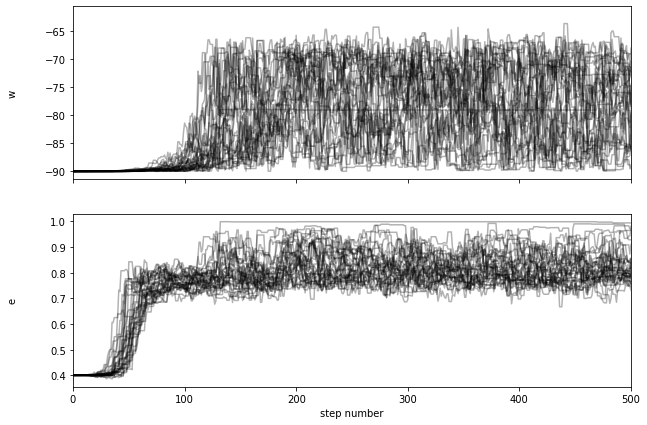

In [193]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [194]:
import corner

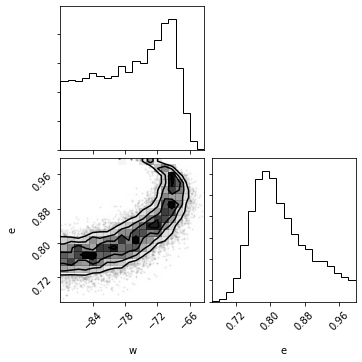

In [195]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)